# **Sentiment Analysis and Opinion Mining on Customer Reviews using NLP**

 SETUP & LIBRARIES

In [10]:
# Basic
import pandas as pd
import numpy as np

# NLP
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


 LOAD DATASET

In [11]:
from google.colab import files

uploaded = files.upload()

Saving yelp.csv to yelp (2).csv


1.DATA PREPROCESSING & CLEANING

TF-IDF

In [9]:
df = pd.read_csv('yelp.csv')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

SENTIMENT LABEL CREATION (USING RATINGS)

In [12]:
def sentiment_label(star):
    if star >= 4:
        return 'positive'
    elif star == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['stars'].apply(sentiment_label)
df['sentiment'].value_counts()

,count
sentiment,
positive,6863
negative,1676
neutral,1461


2.EXPLORATORY TEXT ANALYSIS – WORD CLOUDS

Text(0.5, 1.0, 'Negative Reviews')

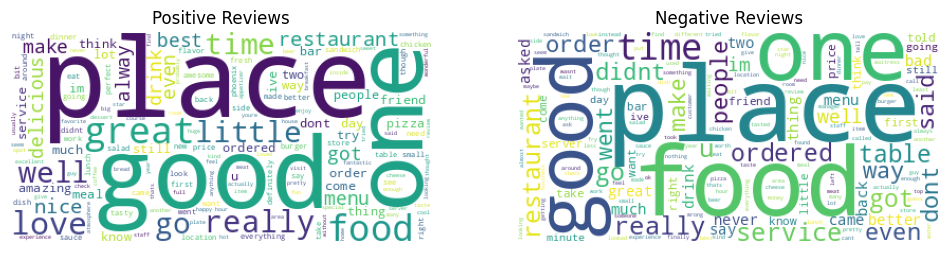

In [13]:
from wordcloud import WordCloud

positive_text = " ".join(df[df['sentiment']=='positive']['clean_text'])
negative_text = " ".join(df[df['sentiment']=='negative']['clean_text'])

wc_pos = WordCloud(background_color='white').generate(positive_text)
wc_neg = WordCloud(background_color='white').generate(negative_text)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.axis('off')
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.axis('off')
plt.title("Negative Reviews")


N-GRAM ANALYSIS

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,2), max_features=10)
X_ngrams = cv.fit_transform(df['clean_text'])

pd.Series(X_ngrams.toarray().sum(axis=0), index=cv.get_feature_names_out())


,0
dont know,302
first time,389
food good,304
go back,532
great place,339
happy hour,612
ice cream,311
next time,310
pretty good,383
really good,418


TF-IDF FEATURE EXTRACTION

In [15]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']


TRAIN-TEST SPLIT

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


3.SENTIMENT CLASSIFICATION

LOGISTIC REGRESSION

In [17]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


[[ 169   29  110]
 [  29   56  204]
 [  21   22 1360]]
              precision    recall  f1-score   support

    negative       0.77      0.55      0.64       308
     neutral       0.52      0.19      0.28       289
    positive       0.81      0.97      0.88      1403

    accuracy                           0.79      2000
   macro avg       0.70      0.57      0.60      2000
weighted avg       0.76      0.79      0.76      2000



NAIVE BAYES

In [18]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

    negative       0.86      0.16      0.26       308
     neutral       0.00      0.00      0.00       289
    positive       0.72      1.00      0.84      1403

    accuracy                           0.72      2000
   macro avg       0.53      0.38      0.37      2000
weighted avg       0.64      0.72      0.63      2000



SVM

In [19]:
svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

    negative       0.71      0.63      0.67       308
     neutral       0.43      0.28      0.34       289
    positive       0.84      0.93      0.88      1403

    accuracy                           0.79      2000
   macro avg       0.66      0.61      0.63      2000
weighted avg       0.76      0.79      0.77      2000



4.TOPIC MODELLING AND KEYWORD EXTRACTION

TOPIC MODELING (LDA)

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

words = tfidf.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([words[j] for j in topic.argsort()[-10:]])


Topic 0:
['love', 'cheese', 'great', 'place', 'fry', 'salad', 'sandwich', 'good', 'burger', 'pizza']
Topic 1:
['ever', 'food', 'bloody', 'bosa', 'zipps', 'dunkin', 'gelato', 'barber', 'closed', 'donut']
Topic 2:
['love', 'like', 'dish', 'service', 'restaurant', 'chicken', 'great', 'place', 'good', 'food']
Topic 3:
['night', 'beer', 'drink', 'time', 'good', 'service', 'bar', 'place', 'food', 'great']
Topic 4:
['would', 'good', 'go', 'time', 'great', 'store', 'one', 'like', 'get', 'place']


5.TREND ANALYSIS – SENTIMENT OVER TIME

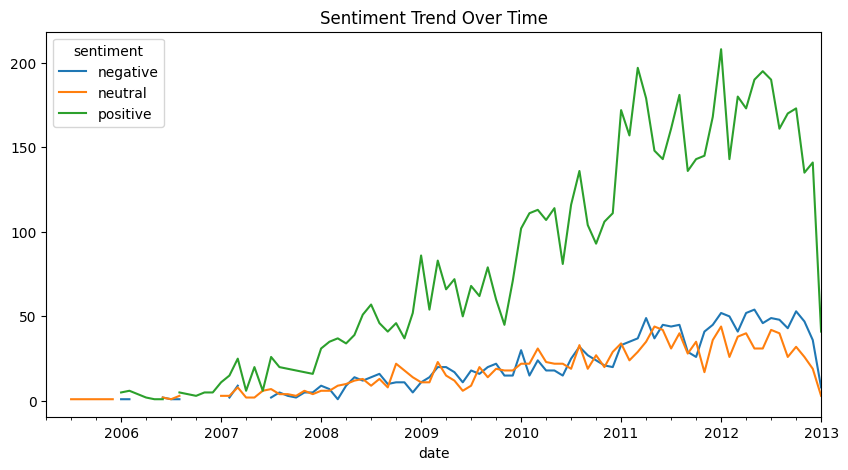

In [21]:
df['date'] = pd.to_datetime(df['date'])
trend = df.groupby([df['date'].dt.to_period('M'), 'sentiment']).size().unstack()

trend.plot(figsize=(10,5))
plt.title("Sentiment Trend Over Time")
plt.show()


6.NAMED ENTITY RECOGNITION (NER)

In [22]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp(df['text'].iloc[0])
for ent in doc.ents:
    print(ent.text, ent.label_)


Saturday DATE
morning TIME
2 CARDINAL


7.ACTIONABLE INSIGHTS

In [24]:
# Top keywords in positive and negative reviews
from sklearn.feature_extraction.text import CountVectorizer

# Positive reviews
pos_reviews = df[df['sentiment'] == 'positive']['clean_text']
neg_reviews = df[df['sentiment'] == 'negative']['clean_text']

cv = CountVectorizer(max_features=20)

pos_words = cv.fit_transform(pos_reviews)
pos_freq = pd.Series(pos_words.toarray().sum(axis=0),
                     index=cv.get_feature_names_out())

neg_words = cv.fit_transform(neg_reviews)
neg_freq = pd.Series(neg_words.toarray().sum(axis=0),
                     index=cv.get_feature_names_out())

print("🔹 Most Loved Features (Positive Keywords):")
print(pos_freq.sort_values(ascending=False))

print("\n🔹 Most Criticized Features (Negative Keywords):")
print(neg_freq.sort_values(ascending=False))


🔹 Most Loved Features (Positive Keywords):
place      4919
good       4559
great      4184
food       3903
like       3037
time       2962
one        2728
get        2613
go         2364
really     2194
service    1984
love       1955
also       1832
back       1741
would      1679
always     1580
best       1571
little     1565
nice       1543
dont       1534
dtype: int64

🔹 Most Criticized Features (Negative Keywords):
food          1355
place         1272
like          1105
good           932
one            888
time           875
get            842
would          772
service        723
go             675
back           666
dont           600
really         559
even           550
didnt          490
ordered        463
order          461
im             460
restaurant     443
got            427
dtype: int64


In [23]:
df.groupby('sentiment')['stars'].mean()


,stars
sentiment,
negative,1.553103
neutral,3.000000
positive,4.486231


In [31]:
high_rating = df[df['stars'] >= 4]['clean_text']
low_rating = df[df['stars'] <= 2]['clean_text']

tfidf_temp = TfidfVectorizer(max_features=15)
X_high = tfidf_temp.fit_transform(high_rating)
high_keywords = tfidf_temp.get_feature_names_out()

tfidf_temp = TfidfVectorizer(max_features=15)
X_low = tfidf_temp.fit_transform(low_rating)
low_keywords = tfidf_temp.get_feature_names_out()

print(" Topics in High Ratings:", high_keywords)
print(" Topics in Low Ratings:", low_keywords)


 Topics in High Ratings: ['also' 'back' 'food' 'get' 'go' 'good' 'great' 'like' 'love' 'one'
 'place' 'really' 'service' 'time' 'would']
 Topics in Low Ratings: ['back' 'didnt' 'dont' 'even' 'food' 'get' 'go' 'good' 'like' 'one'
 'place' 'really' 'service' 'time' 'would']


8.REPORTING AND VISUALIZATION

SENTIMENT DISTRIBUTION (BAR CHART)

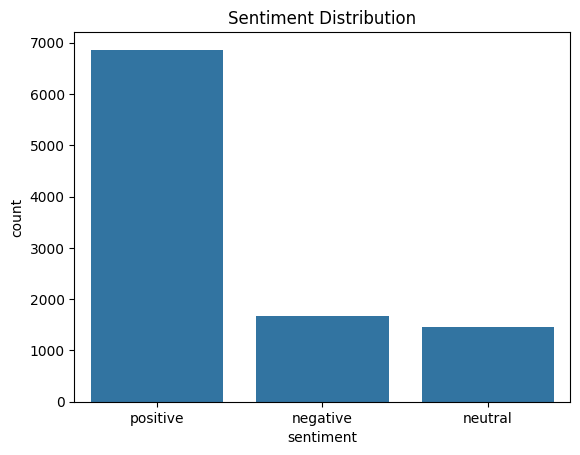

In [27]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


RATING VS SENTIMENT HEATMAP

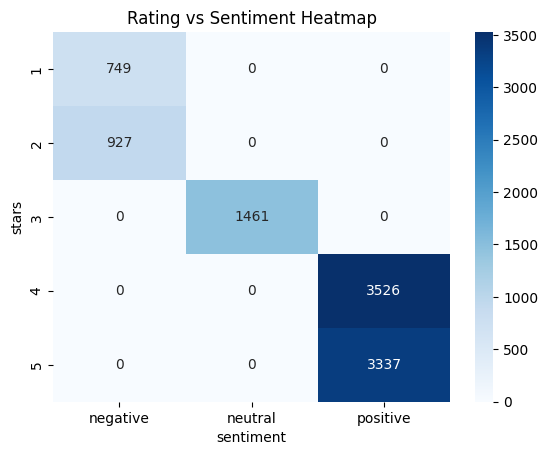

In [29]:
rating_sentiment = pd.crosstab(df['stars'], df['sentiment'])

sns.heatmap(rating_sentiment, annot=True, fmt='d', cmap='Blues')
plt.title("Rating vs Sentiment Heatmap")
plt.show()


TOPIC POPULARITY VISUALIZATION (LDA)

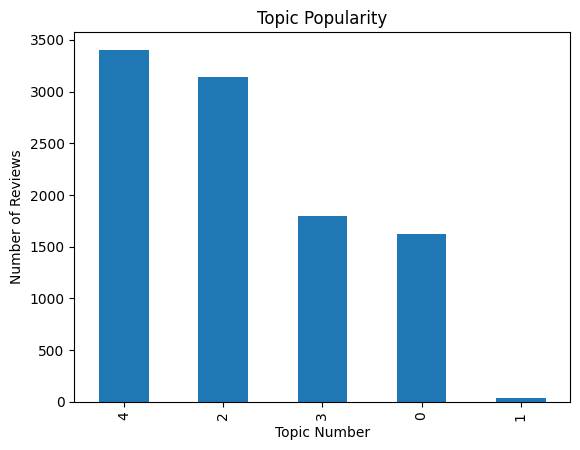

In [30]:
topic_counts = pd.DataFrame(lda.transform(X)).idxmax(axis=1)
topic_counts.value_counts().plot(kind='bar')

plt.title("Topic Popularity")
plt.xlabel("Topic Number")
plt.ylabel("Number of Reviews")
plt.show()
